https://huggingface.co/docs/transformers/en/tasks/image_classification

In [1]:
!nvidia-smi

Sat Apr  6 23:07:04 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA A100-SXM4-80GB          On  | 00000000:07:00.0 Off |                   On |
| N/A   30C    P0              56W / 400W |     87MiB / 81920MiB |     N/A      Default |
|                                         |                      |              Enabled |
+-----------------------------------------+----------------------+--

In [2]:
# Transformers installation
!pip install transformers datasets evaluate
!pip install datasets

# clear output
from IPython.display import clear_output
clear_output()

In [3]:

import torch

# Set the number of CPUs to use
num_cpus = 5
torch.set_num_threads(num_cpus)

# authentication token from the Hugging Face website

In [4]:
# from huggingface_hub import login
# login(token = "hf_qn")


In [5]:
from huggingface_hub import notebook_login
notebook_login()

## Loading the dataset

Start by loading a smaller subset of the Food-101 dataset from the 🤗 Datasets library. This will give you a chance to
experiment and make sure everything works before spending more time training on the full dataset.

In [6]:
import os
from   datasets import load_dataset
import datasets


dataset_name = "food101"
path_dataset = "/raid/scratch/tuchsanai/food101"


dataset  = load_dataset(dataset_name, split="train[:5000]")

if not os.path.exists(path_dataset):
    dataset.save_to_disk(path_dataset)

dataset =  datasets.load_from_disk(path_dataset)


# note that you can also provide several splits:
# dataset = load_dataset("imagefolder", data_files={"train": ["path/to/file1", "path/to/file2"], "test": ["path/to/file3", "path/to/file4"]})

# note that you can push your dataset to the hub very easily (and reload afterwards using load_dataset)!
# dataset.push_to_hub("nielsr/eurosat")
# dataset.push_to_hub("nielsr/eurosat", private=True)

# option 2: local folder
# dataset = load_dataset("imagefolder", data_dir="path_to_folder")


In [7]:
dataset

Dataset({
    features: ['image', 'label'],
    num_rows: 5000
})

Split the dataset's `train` split into a train and test set with the [train_test_split](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.train_test_split) method:

In [8]:
dataset = dataset.train_test_split(test_size=0.2)

In [9]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

Then take a look at an example:

Each example in the dataset has two fields:

- `image`: a PIL image of the food item
- `label`: the label class of the food item

To make it easier for the model to get the label name from the label id, create a dictionary that maps the label name
to an integer and vice versa:

In [10]:
labels = dataset["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = str(i)
    id2label[str(i)] = label

In [11]:
print(labels)
print("there are", len(labels), "labels")

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare', 'beet_salad', 'beignets', 'bibimbap', 'bread_pudding', 'breakfast_burrito', 'bruschetta', 'caesar_salad', 'cannoli', 'caprese_salad', 'carrot_cake', 'ceviche', 'cheesecake', 'cheese_plate', 'chicken_curry', 'chicken_quesadilla', 'chicken_wings', 'chocolate_cake', 'chocolate_mousse', 'churros', 'clam_chowder', 'club_sandwich', 'crab_cakes', 'creme_brulee', 'croque_madame', 'cup_cakes', 'deviled_eggs', 'donuts', 'dumplings', 'edamame', 'eggs_benedict', 'escargots', 'falafel', 'filet_mignon', 'fish_and_chips', 'foie_gras', 'french_fries', 'french_onion_soup', 'french_toast', 'fried_calamari', 'fried_rice', 'frozen_yogurt', 'garlic_bread', 'gnocchi', 'greek_salad', 'grilled_cheese_sandwich', 'grilled_salmon', 'guacamole', 'gyoza', 'hamburger', 'hot_and_sour_soup', 'hot_dog', 'huevos_rancheros', 'hummus', 'ice_cream', 'lasagna', 'lobster_bisque', 'lobster_roll_sandwich', 'macaroni_and_cheese', 'macarons', 'miso_sou

In [12]:
print(id2label)

{'0': 'apple_pie', '1': 'baby_back_ribs', '2': 'baklava', '3': 'beef_carpaccio', '4': 'beef_tartare', '5': 'beet_salad', '6': 'beignets', '7': 'bibimbap', '8': 'bread_pudding', '9': 'breakfast_burrito', '10': 'bruschetta', '11': 'caesar_salad', '12': 'cannoli', '13': 'caprese_salad', '14': 'carrot_cake', '15': 'ceviche', '16': 'cheesecake', '17': 'cheese_plate', '18': 'chicken_curry', '19': 'chicken_quesadilla', '20': 'chicken_wings', '21': 'chocolate_cake', '22': 'chocolate_mousse', '23': 'churros', '24': 'clam_chowder', '25': 'club_sandwich', '26': 'crab_cakes', '27': 'creme_brulee', '28': 'croque_madame', '29': 'cup_cakes', '30': 'deviled_eggs', '31': 'donuts', '32': 'dumplings', '33': 'edamame', '34': 'eggs_benedict', '35': 'escargots', '36': 'falafel', '37': 'filet_mignon', '38': 'fish_and_chips', '39': 'foie_gras', '40': 'french_fries', '41': 'french_onion_soup', '42': 'french_toast', '43': 'fried_calamari', '44': 'fried_rice', '45': 'frozen_yogurt', '46': 'garlic_bread', '47': '

In [13]:
print(label2id)

{'apple_pie': '0', 'baby_back_ribs': '1', 'baklava': '2', 'beef_carpaccio': '3', 'beef_tartare': '4', 'beet_salad': '5', 'beignets': '6', 'bibimbap': '7', 'bread_pudding': '8', 'breakfast_burrito': '9', 'bruschetta': '10', 'caesar_salad': '11', 'cannoli': '12', 'caprese_salad': '13', 'carrot_cake': '14', 'ceviche': '15', 'cheesecake': '16', 'cheese_plate': '17', 'chicken_curry': '18', 'chicken_quesadilla': '19', 'chicken_wings': '20', 'chocolate_cake': '21', 'chocolate_mousse': '22', 'churros': '23', 'clam_chowder': '24', 'club_sandwich': '25', 'crab_cakes': '26', 'creme_brulee': '27', 'croque_madame': '28', 'cup_cakes': '29', 'deviled_eggs': '30', 'donuts': '31', 'dumplings': '32', 'edamame': '33', 'eggs_benedict': '34', 'escargots': '35', 'falafel': '36', 'filet_mignon': '37', 'fish_and_chips': '38', 'foie_gras': '39', 'french_fries': '40', 'french_onion_soup': '41', 'french_toast': '42', 'fried_calamari': '43', 'fried_rice': '44', 'frozen_yogurt': '45', 'garlic_bread': '46', 'gnocch

In [14]:
ex = dataset['train'][0]


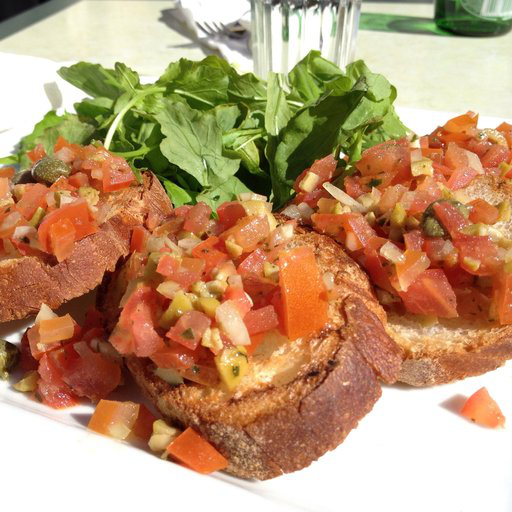

In [15]:
image = ex['image']
image

In [16]:
ex['label']

10

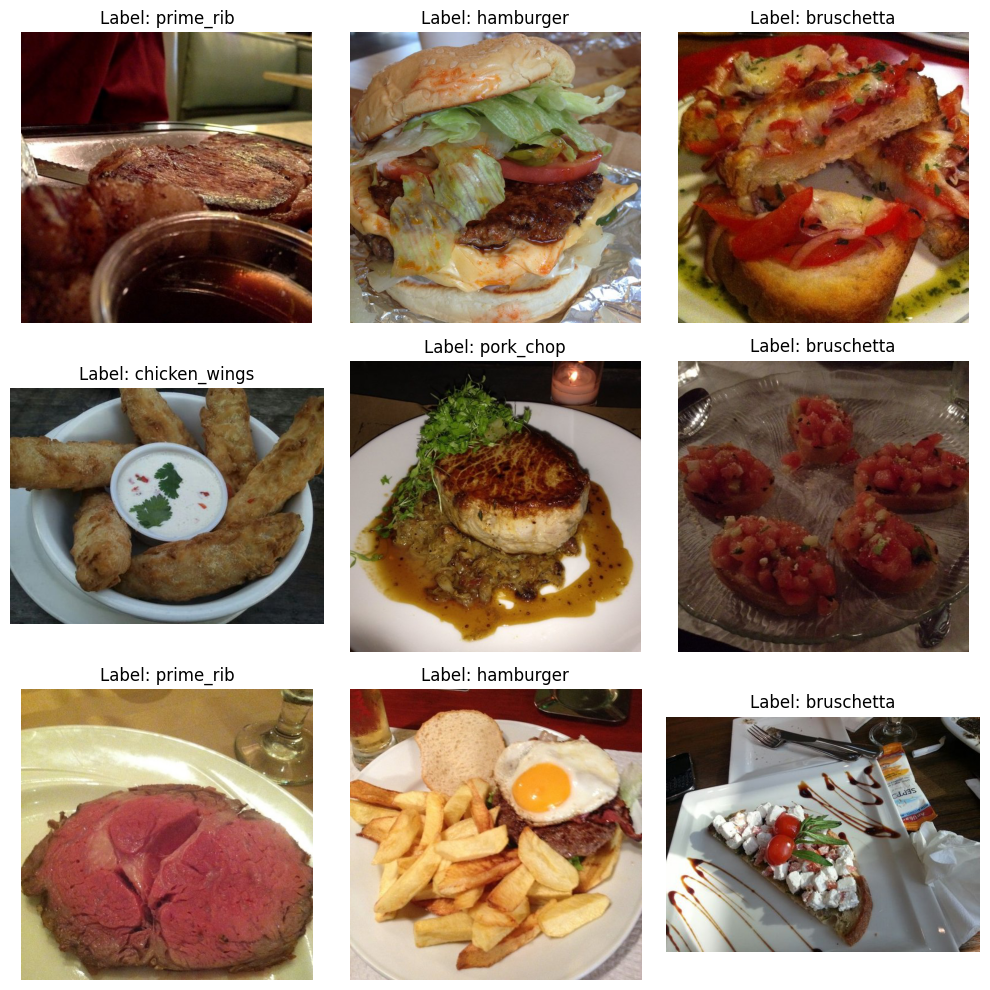

In [17]:
import matplotlib.pyplot as plt
import random
from datasets import load_dataset




# Get the train and test datasets
train_dataset = dataset["train"]
test_dataset = dataset["test"]

# Define the number of rows and columns for the grid plot
num_rows = 3
num_cols = 3

# Create a figure and axes for the grid plot
fig, axes = plt.subplots(num_rows, num_cols, figsize=(10, 10))

# Get random indices for the train dataset
random_indices = random.sample(range(len(train_dataset)), num_rows * num_cols)

# Iterate over the random indices and plot the images in the grid
for i, ax in enumerate(axes.flat):
    if i < len(random_indices):
        idx = random_indices[i]
        image, label = train_dataset[idx]["image"], train_dataset[idx]["label"]
        ax.imshow(image)
        ax.set_title(f"Label: { id2label[str(label)] }")
        ax.axis("off")
    else:
        ax.axis("off")

# Adjust the spacing between subplots
plt.tight_layout()

# Display the grid plot
plt.show()

## Preprocess

The next step is to load a ViT image processor to process the image into a tensor:

In [18]:
from transformers import AutoImageProcessor

checkpoint      = "google/vit-base-patch16-224-in21k"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)

In [19]:
image_processor

ViTImageProcessor {
  "_valid_processor_keys": [
    "images",
    "do_resize",
    "size",
    "resample",
    "do_rescale",
    "rescale_factor",
    "do_normalize",
    "image_mean",
    "image_std",
    "return_tensors",
    "data_format",
    "input_data_format"
  ],
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessor",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

Apply some image transformations to the images to make the model more robust against overfitting. Here you'll use torchvision's [`transforms`](https://pytorch.org/vision/stable/transforms.html) module, but you can also use any image library you like.

Crop a random part of the image, resize it, and normalize it with the image mean and standard deviation:

In [20]:
out = image_processor(image, return_tensors='pt')

print(out.keys())

out['pixel_values'].shape

dict_keys(['pixel_values'])


torch.Size([1, 3, 224, 224])

In [21]:
def transform(example_batch):
    # Take a list of PIL images and turn them to pixel values
    inputs =image_processor ([x for x in example_batch['image']], return_tensors='pt')
    inputs['label'] = example_batch['label']
    return inputs


food = dataset.with_transform(transform)

food

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 4000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1000
    })
})

To apply the preprocessing function over the entire dataset, use 🤗 Datasets [with_transform](https://huggingface.co/docs/datasets/main/en/package_reference/main_classes#datasets.Dataset.with_transform) method. The transforms are applied on the fly when you load an element of the dataset:

In [22]:
food['train'][0]

{'pixel_values': tensor([[[-0.8588, -0.8588, -0.8510,  ...,  0.4039,  0.4275,  0.4275],
          [-0.8667, -0.8588, -0.8431,  ...,  0.4353,  0.4431,  0.4667],
          [-0.8745, -0.8588, -0.8431,  ...,  0.4667,  0.4588,  0.4980],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  0.9529,  0.9294,  0.9059],
          [ 1.0000,  1.0000,  1.0000,  ...,  0.9529,  0.9216,  0.9059],
          [ 1.0000,  1.0000,  1.0000,  ...,  0.9451,  0.9216,  0.8980]],
 
         [[-0.8588, -0.8588, -0.8510,  ...,  0.6235,  0.6549,  0.6392],
          [-0.8667, -0.8588, -0.8431,  ...,  0.6392,  0.6549,  0.6627],
          [-0.8745, -0.8588, -0.8431,  ...,  0.6627,  0.6471,  0.6863],
          ...,
          [ 1.0000,  1.0000,  1.0000,  ...,  0.9843,  0.9608,  0.9373],
          [ 1.0000,  1.0000,  1.0000,  ...,  0.9765,  0.9529,  0.9373],
          [ 1.0000,  1.0000,  1.0000,  ...,  0.9765,  0.9529,  0.9294]],
 
         [[-0.8431, -0.8431, -0.8353,  ...,  0.4039,  0.4353,  0.4667],
          [-

# Define our data collator

In [23]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

## Evaluate

Including a metric during training is often helpful for evaluating your model's performance. You can quickly load an
evaluation method with the 🤗 [Evaluate](https://huggingface.co/docs/evaluate/index) library. For this task, load
the [accuracy](https://huggingface.co/spaces/evaluate-metric/accuracy) metric (see the 🤗 Evaluate [quick tour](https://huggingface.co/docs/evaluate/a_quick_tour) to learn more about how to load and compute a metric):

Then create a function that passes your predictions and labels to [compute](https://huggingface.co/docs/evaluate/main/en/package_reference/main_classes#evaluate.EvaluationModule.compute) to calculate the accuracy:

In [24]:
import evaluate
import numpy as np

metric = evaluate.load("accuracy")


def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return metric.compute(predictions=predictions, references=labels)

Your `compute_metrics` function is ready to go now, and you'll return to it when you set up your training.

## Train

<Tip>

If you aren't familiar with finetuning a model with the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer), take a look at the basic tutorial [here](https://huggingface.co/docs/transformers/main/en/tasks/../training#train-with-pytorch-trainer)!

</Tip>

You're ready to start training your model now! Load ViT with [AutoModelForImageClassification](https://huggingface.co/docs/transformers/main/en/model_doc/auto#transformers.AutoModelForImageClassification). Specify the number of labels along with the number of expected labels, and the label mappings:

In [25]:
from transformers import AutoModelForImageClassification, TrainingArguments, Trainer

model = AutoModelForImageClassification.from_pretrained(
    checkpoint,
    num_labels=len(labels),
    id2label=id2label,
    label2id=label2id,
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [26]:
model

ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=7

At this point, only three steps remain:

1. Define your training hyperparameters in [TrainingArguments](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.TrainingArguments). It is important you don't remove unused columns because that'll drop the `image` column. Without the `image` column, you can't create `pixel_values`. Set `remove_unused_columns=False` to prevent this behavior! The only other required parameter is `output_dir` which specifies where to save your model. You'll push this model to the Hub by setting `push_to_hub=True` (you need to be signed in to Hugging Face to upload your model). At the end of each epoch, the [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) will evaluate the accuracy and save the training checkpoint.
2. Pass the training arguments to [Trainer](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer) along with the model, dataset, tokenizer, data collator, and `compute_metrics` function.
3. Call [train()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.train) to finetune your model.

In [27]:
training_args = TrainingArguments(
    output_dir="my_awesome_food_model",
    fp16=True,
    remove_unused_columns=False,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=5e-5,
    per_device_train_batch_size=64,
    gradient_accumulation_steps=2,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    logging_steps=10,
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    data_collator=collate_fn,
    train_dataset=food["train"],
    eval_dataset=food["test"],
    tokenizer=image_processor,
    compute_metrics=compute_metrics,
)

trainer.train()

/home/tuchsanai/.conda/envs/torch/lib/python3.12/site-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Epoch,Training Loss,Validation Loss


KeyboardInterrupt: 

Once training is completed, share your model to the Hub with the [push_to_hub()](https://huggingface.co/docs/transformers/main/en/main_classes/trainer#transformers.Trainer.push_to_hub) method so everyone can use your model:

In [ ]:
trainer.push_to_hub()

training_args.bin:   0%|          | 0.00/4.92k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/344M [00:00<?, ?B/s]

Upload 2 LFS files:   0%|          | 0/2 [00:00<?, ?it/s]

<Tip>

For a more in-depth example of how to finetune a model for image classification, take a look at the corresponding [PyTorch notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/examples/image_classification.ipynb).

</Tip>

## Inference

Great, now that you've fine-tuned a model, you can use it for inference!

Load an image you'd like to run inference on:

In [ ]:
ds = load_dataset("food101", split="validation[:10]")
image = ds["image"][0]

<div class="flex justify-center">
    <img src="https://huggingface.co/datasets/huggingface/documentation-images/resolve/main/beignets-task-guide.png" alt="image of beignets"/>
</div>

The simplest way to try out your finetuned model for inference is to use it in a [pipeline()](https://huggingface.co/docs/transformers/main/en/main_classes/pipelines#transformers.pipeline). Instantiate a `pipeline` for image classification with your model, and pass your image to it:

In [ ]:
from transformers import pipeline

classifier = pipeline("image-classification", model="my_awesome_food_model")
classifier(image)

[{'label': 'beignets', 'score': 0.15707267820835114},
 {'label': 'prime_rib', 'score': 0.01702268421649933},
 {'label': 'chicken_wings', 'score': 0.014698311686515808},
 {'label': 'bruschetta', 'score': 0.013882173225283623},
 {'label': 'ramen', 'score': 0.013234714977443218}]

You can also manually replicate the results of the `pipeline` if you'd like:

Load an image processor to preprocess the image and return the `input` as PyTorch tensors:

In [ ]:
from transformers import AutoImageProcessor
import torch

image_processor = AutoImageProcessor.from_pretrained("my_awesome_food_model")
inputs = image_processor(image, return_tensors="pt")

Pass your inputs to the model and return the logits:

In [ ]:
from transformers import AutoModelForImageClassification

model = AutoModelForImageClassification.from_pretrained("my_awesome_food_model")
with torch.no_grad():
    logits = model(**inputs).logits

Get the predicted label with the highest probability, and use the model's `id2label` mapping to convert it to a label:

In [ ]:
predicted_label = logits.argmax(-1).item()
model.config.id2label[predicted_label]

'beignets'